# import library

https://www.datacamp.com/community/tutorials/installation-of-pyspark

In [1]:
import findspark
import seaborn as sns
from matplotlib import pyplot as plt

findspark.init("/home/om/spark-3.1.1-bin-hadoop2.7")
import numpy as np
import pandas as pd
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split

# create session

In [2]:
conf = SparkConf().setAppName("MyApp").setMaster("local")
sc = SparkContext(conf=conf)

In [3]:
spark = (
    SparkSession.builder.appName("Python Spark Transactions")
    .config("spark.some.config.option", "some-value")
    .getOrCreate()
)

In [4]:
spark

# read the transactions file

In [5]:
data_ts = spark.read.load(
    "transactions.csv", format="csv", header="true", inferSchema="true"
)

In [6]:
type(data_ts)

pyspark.sql.dataframe.DataFrame

In [11]:
data_ts.groupBy("isFraud").count().show()

+-------+------+
|isFraud| count|
+-------+------+
|   true| 11302|
|  false|630612|
+-------+------+



In [8]:
data = data_ts.toPandas()
data = data.sample(frac=1)

In [9]:
data.isFraud = data.isFraud.astype(int)

In [10]:
data.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch
176005,822203001,822203001,5000,889.87,2016-11-25 17:56:36,96.23,ebay.com,US,US,9.0,...,11/1/2014,24/10/2016,180,180,6060,PURCHASE,0,4110.13,False,False
155632,445516477,445516477,10000,708.55,2016-11-18 09:33:45,652.10,AMC #692956,US,US,9.0,...,26/11/2013,15/1/2016,329,329,1982,PURCHASE,0,9291.45,True,False
370534,900828152,900828152,7500,4805.90,2016-08-23 10:14:09,114.23,Lyft,US,US,9.0,...,28/4/2015,26/6/2016,237,237,6444,PURCHASE,0,2694.10,False,False
278856,314506271,314506271,250,250.00,2016-06-14 19:36:36,60.36,KFC #113520,US,US,2.0,...,15/6/2015,23/4/2016,815,815,2640,PURCHASE,0,0.00,False,False
156446,387040271,387040271,5000,1327.44,2016-04-01 10:07:27,242.44,EZ Putt Putt #551896,US,US,90.0,...,6/12/2011,7/3/2016,347,347,1972,PURCHASE,0,3672.56,True,False


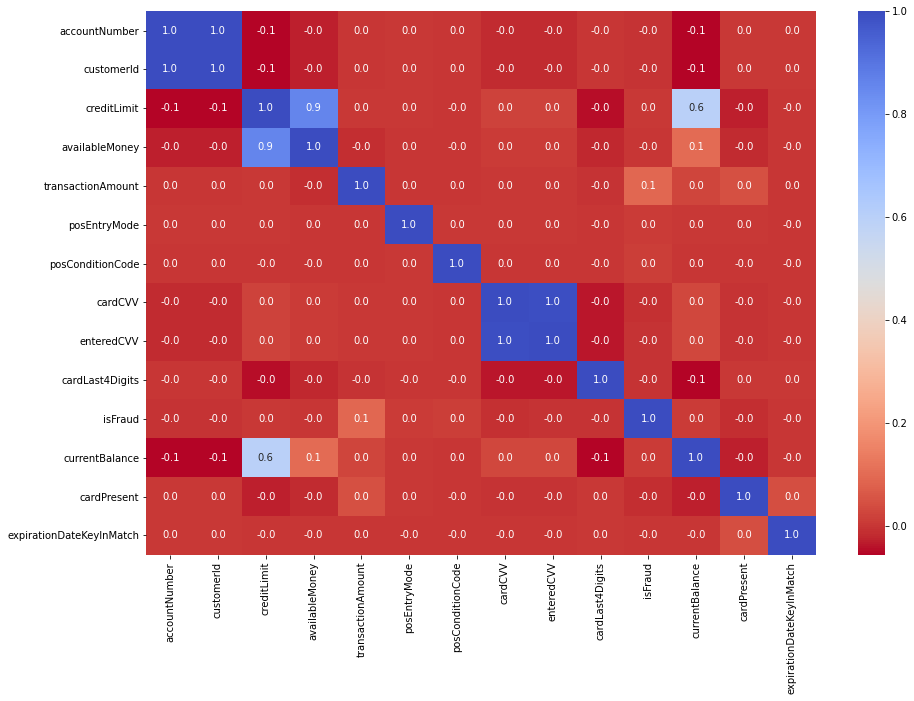

In [12]:
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), cmap=plt.cm.coolwarm_r, annot=True, fmt=".1f");

In [13]:
data.dtypes

accountNumber                        int32
customerId                           int32
creditLimit                          int32
availableMoney                     float64
transactionDateTime         datetime64[ns]
transactionAmount                  float64
merchantName                        object
acqCountry                          object
merchantCountryCode                 object
posEntryMode                       float64
posConditionCode                   float64
merchantCategoryCode                object
currentExpDate                      object
accountOpenDate                     object
dateOfLastAddressChange             object
cardCVV                              int32
enteredCVV                           int32
cardLast4Digits                      int32
transactionType                     object
isFraud                              int64
currentBalance                     float64
cardPresent                           bool
expirationDateKeyInMatch              bool
dtype: obje

In [14]:
data.transactionDateTime = data.transactionDateTime.astype(str)

In [15]:
# amount of fraud classes 11302 rows.
fraud_df = data.loc[data["isFraud"] == 1]
non_fraud_df = data.loc[data["isFraud"] == 0][:11302]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.shape

(22604, 23)

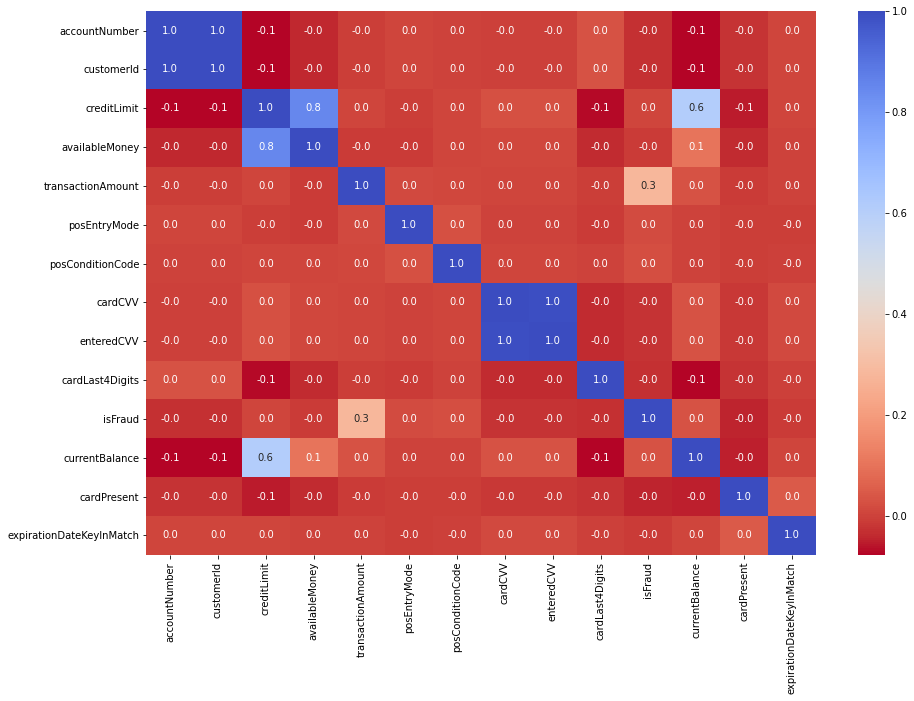

In [16]:
plt.figure(figsize=(15, 10))
sns.heatmap(new_df.corr(), cmap=plt.cm.coolwarm_r, annot=True, fmt=".1f");

In [17]:
new_df.corr().unstack().sort_values(ascending=False).drop_duplicates()

accountNumber    accountNumber        1.000000
cardCVV          enteredCVV           0.993772
creditLimit      availableMoney       0.849745
                 currentBalance       0.611240
isFraud          transactionAmount    0.278030
                                        ...   
creditLimit      cardPresent         -0.052398
                 cardLast4Digits     -0.068146
accountNumber    creditLimit         -0.073065
cardLast4Digits  currentBalance      -0.073403
customerId       currentBalance      -0.075951
Length: 79, dtype: float64

In [18]:
target_col = "isFraud"
feature_cols = new_df.drop(target_col, axis=1).columns

dummy_df = new_df.copy()
dummy_df["dummy_col"] = 1
df_0 = dummy_df.loc[dummy_df[target_col] == 0]
df_1 = dummy_df.loc[dummy_df[target_col] == 1]


def get_cumsum_mae(col_inspected):
    cumsum_0 = df_0.groupby([col_inspected])[["dummy_col"]].count().cumsum()
    cumsum_0 = (cumsum_0 / len(df_0)).reset_index()
    cumsum_1 = df_1.groupby([col_inspected])[["dummy_col"]].count().cumsum()
    cumsum_1 = (cumsum_1 / len(df_1)).reset_index()

    cumsum_compare = (
        cumsum_0.merge(cumsum_1, how="outer", on=col_inspected, suffixes=("_0", "_1"))
        .sort_values(col_inspected)
        .reset_index(drop=True)
        .fillna(method="ffill")
        .fillna(0)
    )
    return np.mean(
        np.abs(cumsum_compare["dummy_col_0"] - cumsum_compare["dummy_col_1"])
    )


df_features = pd.DataFrame()
df_features["feature_name"] = feature_cols
df_features["cumsum_diff_mean"] = df_features["feature_name"].map(get_cumsum_mae)
df_features.sort_values("cumsum_diff_mean", ascending=False)

,feature_name,cumsum_diff_mean
5,transactionAmount,0.187715
9,posEntryMode,0.054751
19,currentBalance,0.028162
4,transactionDateTime,0.024655
11,merchantCategoryCode,0.024434
20,cardPresent,0.022916
6,merchantName,0.019050
1,customerId,0.018539
0,accountNumber,0.018539
15,cardCVV,0.016550


In [19]:
dfff = spark.createDataFrame(new_df)
from pyspark.sql.functions import *
from pyspark.sql.window import Window

win = Window().orderBy("transactionAmount")
dfff = dfff.withColumn("idx", row_number().over(win))

In [20]:
dfff = dfff[
    [
        "transactionAmount",
        "posEntryMode",
        "currentBalance",
        # "merchantCategoryCode",
        "isFraud",
        "idx",
    ]
]

In [21]:
dfff.head()

Row(transactionAmount=0.0, posEntryMode=9.0, currentBalance=1393.66, isFraud=0, idx=1)

In [22]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, VectorIndexer
from pyspark.ml.linalg import DenseVector

In [23]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [24]:
dfff.columns

['transactionAmount', 'posEntryMode', 'currentBalance', 'isFraud', 'idx']

In [25]:
training_df = dfff.rdd.map(lambda x: (DenseVector(x[0:2]), x[3], x[4]))

training_df = spark.createDataFrame(training_df, ["features", "label", "index"])

training_df.head(3)

[Row(features=DenseVector([0.0, 9.0]), label=0, index=1),
 Row(features=DenseVector([0.0, 90.0]), label=1, index=2),
 Row(features=DenseVector([0.0, 9.0]), label=0, index=3)]

In [26]:
training_df = training_df.select("index", "features", "label")
train_data, test_data = training_df.randomSplit([0.8, 0.2], seed=1234)

In [27]:
train_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 9060|
|    1| 9049|
+-----+-----+



In [28]:
test_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 2242|
|    1| 2253|
+-----+-----+



In [29]:
gbt = GBTClassifier(featuresCol="features", maxIter=100, maxDepth=8)

In [30]:
model = gbt.fit(train_data)

In [31]:
predictions = model.transform(test_data)

In [32]:
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 2035|
|       1.0| 2460|
+----------+-----+



In [33]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.7037859719600749

In [34]:
predictions = predictions.withColumn(
    "fraudPrediction",
    when((predictions.label == 1) & (predictions.prediction == 1), 1).otherwise(0),
)

In [35]:
predictions.groupBy("fraudPrediction").count().show()

+---------------+-----+
|fraudPrediction|count|
+---------------+-----+
|              1| 1591|
|              0| 2904|
+---------------+-----+



In [36]:
predictions.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 2242|
|    1| 2253|
+-----+-----+



In [37]:
from pyspark.sql.functions import col

In [38]:
accurateFraud = (
    predictions.groupBy("fraudPrediction")
    .count()
    .where(predictions.fraudPrediction == 1)
    .head()[1]
)
totalFraud = (
    predictions.groupBy("label").count().where(predictions.label == 1).head()[1]
)
FraudPredictionAccuracy = (accurateFraud / totalFraud) * 100
FraudPredictionAccuracy

70.61695517088327

In [41]:
tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()
tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()
fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()
fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()

In [43]:
print(
    "True Positive: ",
    tp,
    "\nTrue Negative: ",
    tn,
    "\nFalse Positive: ",
    fp,
    "\nFalse Negative: ",
    fn,
)
print("Recall: ", tp / (tp + fn))
print("Precision: ", tp / (tp + fp))
print("AccuracY: ", FraudPredictionAccuracy)

True Positive:  1591 
True Negative:  1373 
False Positive:  869 
False Negative:  662
Recall:  0.7061695517088327
Precision:  0.6467479674796748
AccuracY:  70.61695517088327
